# Visión por Computadora 1
## TP 2 
## Alumno: Santiago Fux

In [211]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt


#### Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

In [212]:
def create_gauss_filter(h, w, k_size, sigma):
  # Creamos un núcleo Gaussiano unidimensional
  kX = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
  k = kX @ kX.T
  sp = np.zeros((h, w))

  min_x = int((w - k_size) / 2)
  min_y = int((h - k_size) / 2)
  max_x = int((w + k_size) / 2)
  max_y = int((h + k_size) / 2)

  for x in range(w):
    for y in range(h):
      if x >= min_x and x < max_x:
        if y >= min_y and y < max_y:
          sp[y, x] = k[y - min_y, x - min_x]
  return sp, np.fft.fft2(sp)

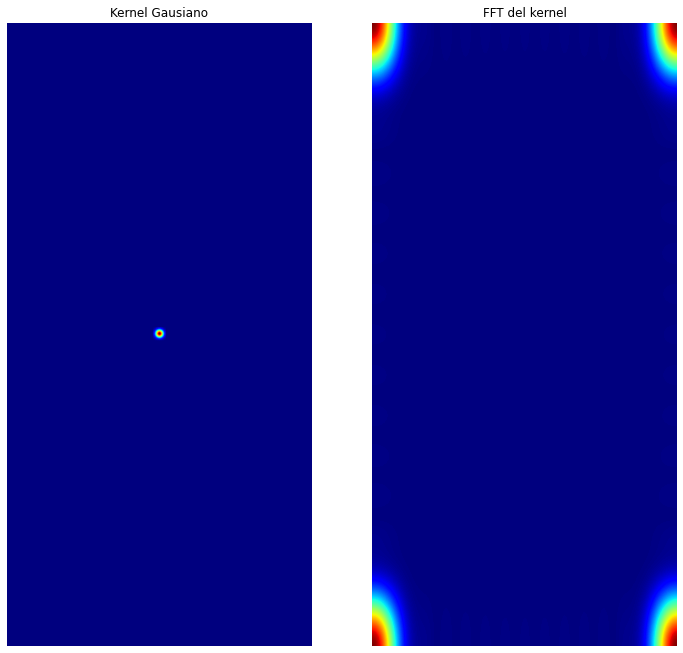

In [213]:
#comparo con lo generado en eel 03.Fourier.ipynb

h = 698
w = 341
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

#### 1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

In [214]:
# aplico filtro a una imagen
img_1 = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)


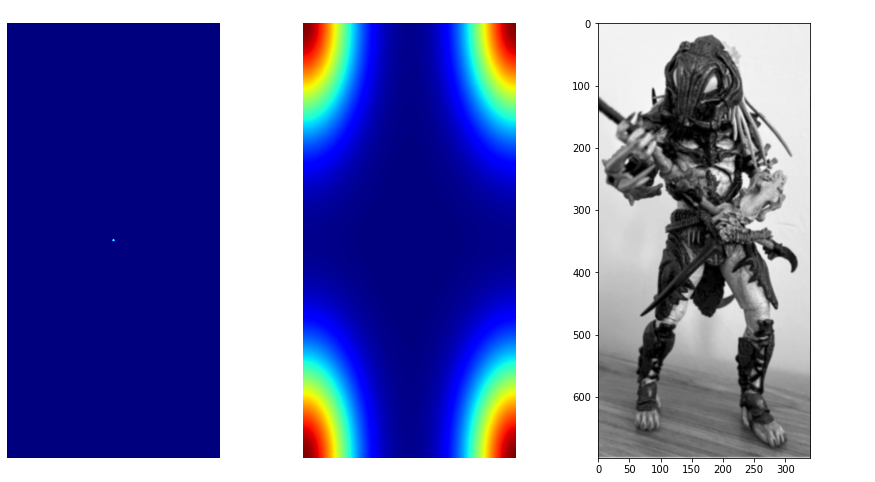

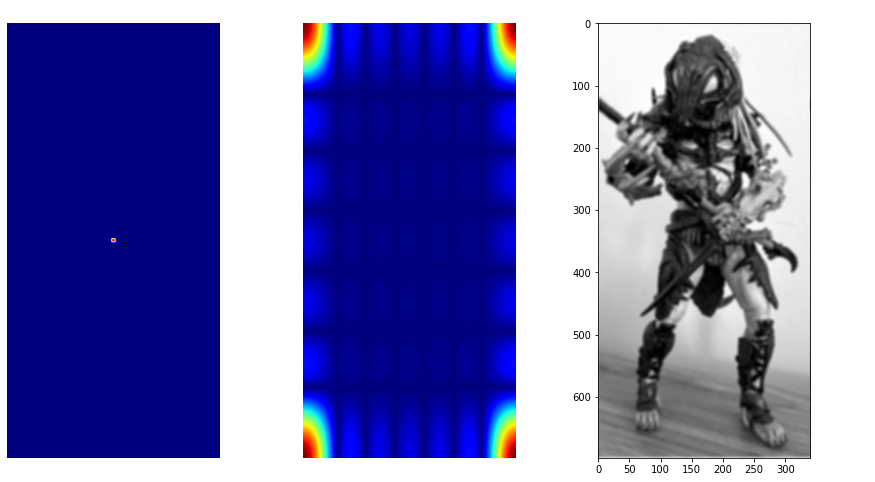

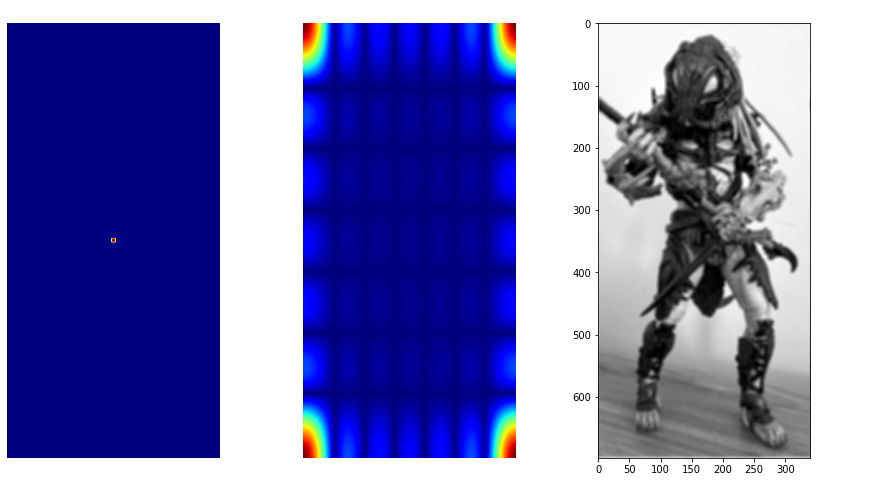

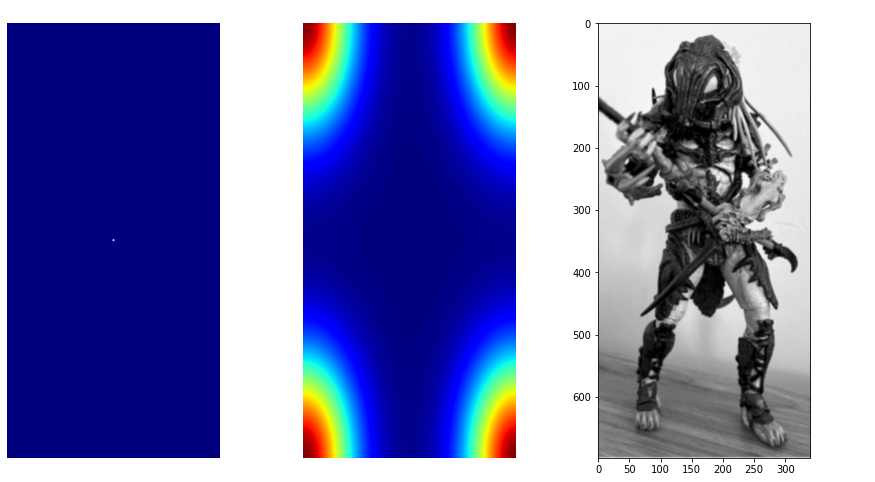

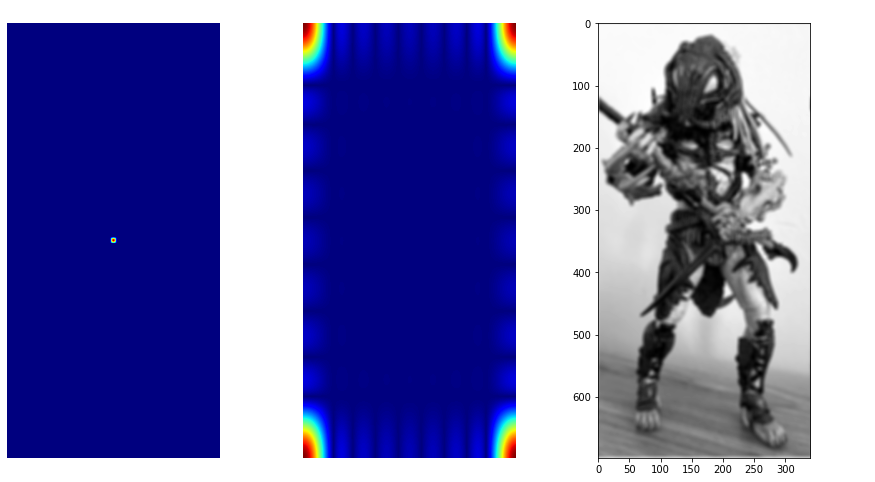

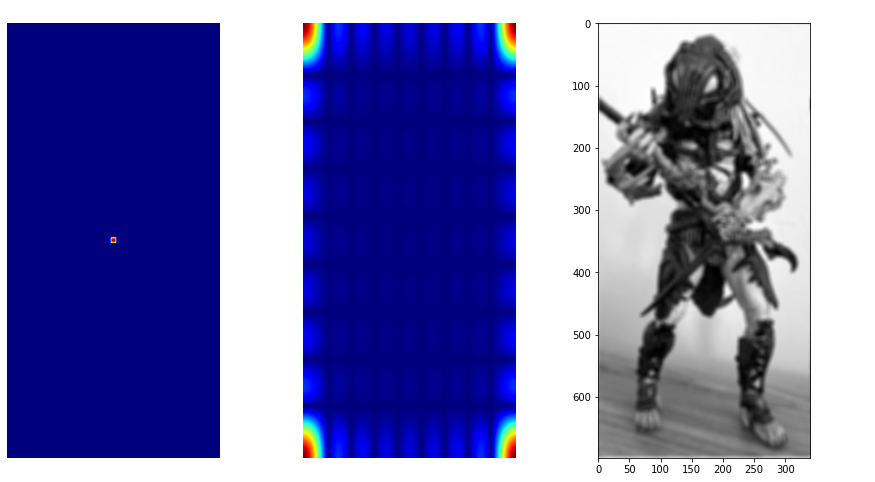

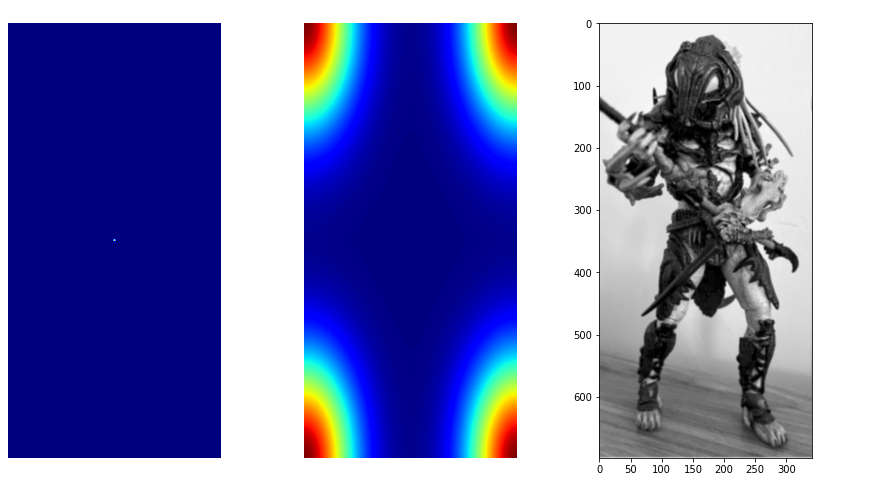

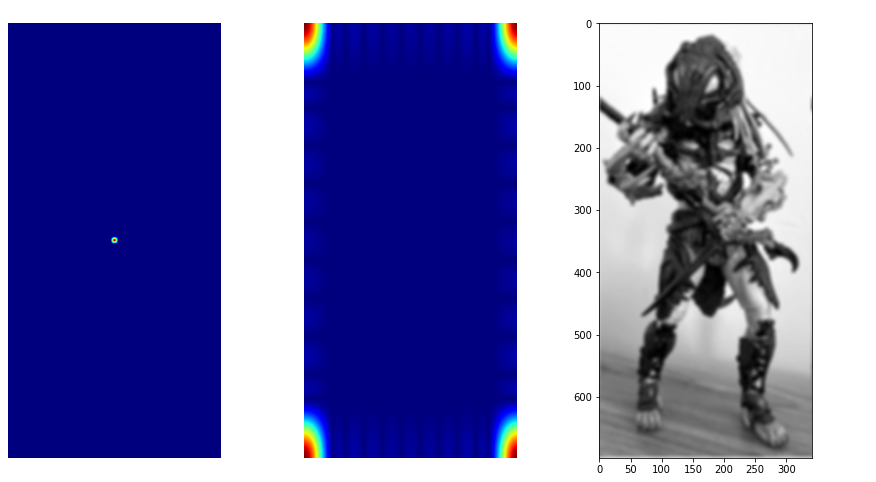

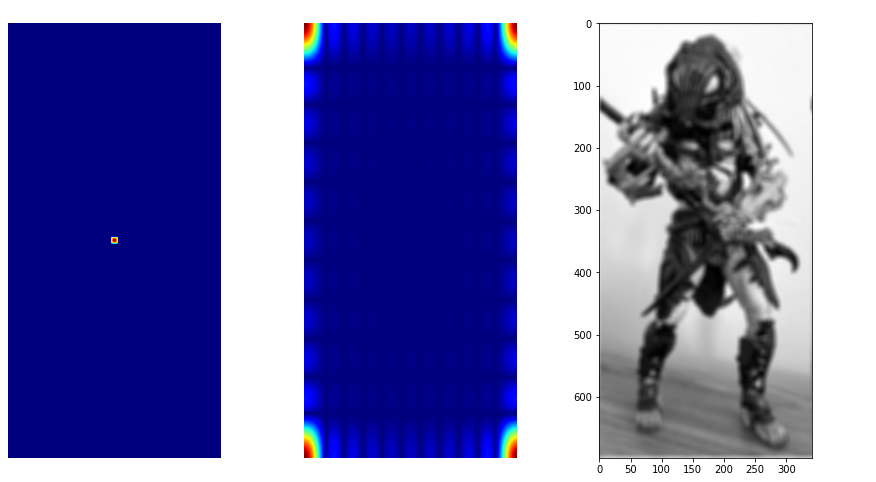

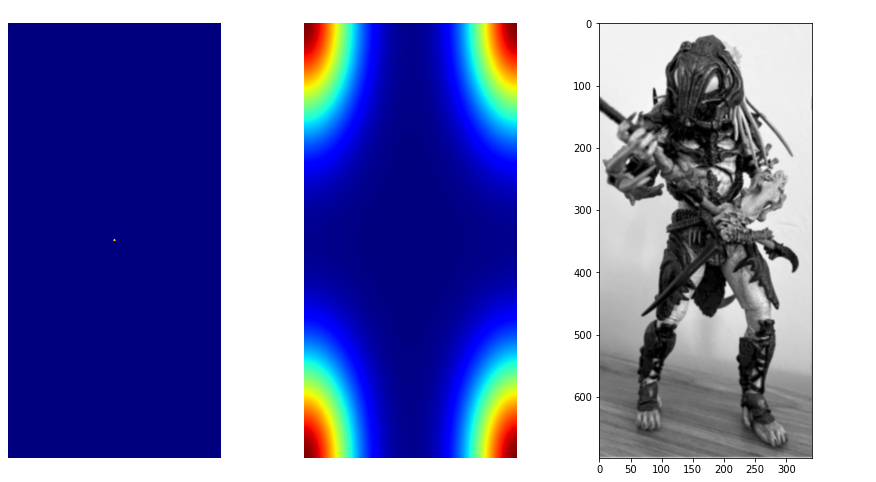

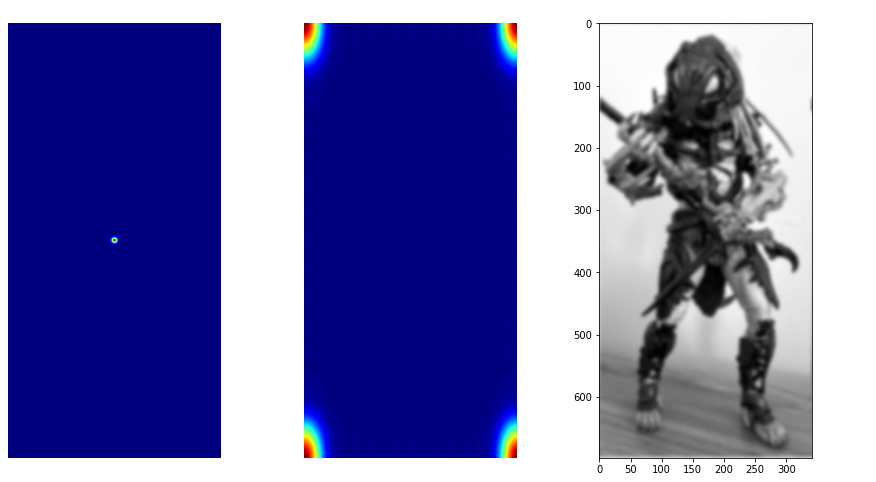

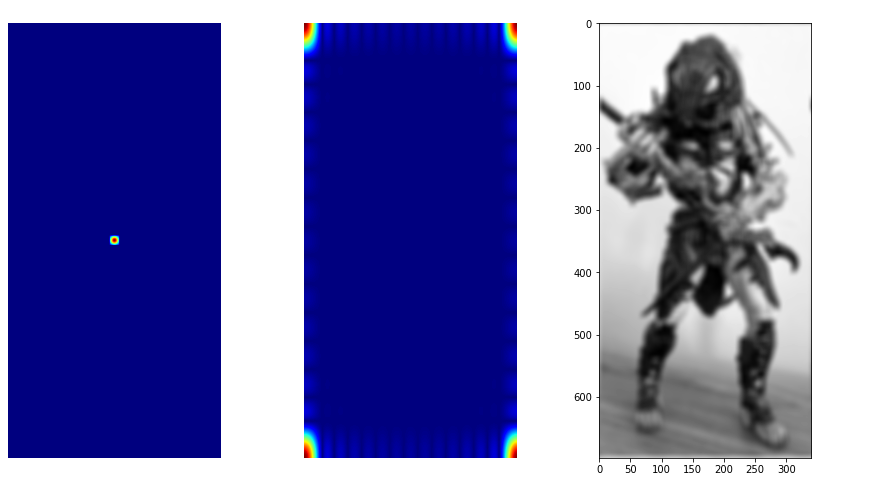

In [215]:

# obtengo el tamaño de la imagen
h, w = img_1.shape

# pruebo para diferentes k_size y sigma
k_sizes=[7,9,11,15]
sigmas = [1, 3, 5]

for k_size in k_sizes:
  for sigma in sigmas:
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=k_size, sigma=sigma)

    # show original images
    plt.figure(figsize=(15,8))

    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title(f"Kernel Gausiano Size={k_size}, Sigma={sigma}", color='w')
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1, 3, 2)

    plt.axis('off')
    plt.title(f"FFT del kernel Size={k_size}, Sigma={sigma}", color='w')
    plt.imshow(np.abs(kernel_tf), cmap='jet')

    # imprimo imagen filtrada
    img_fft = np.fft.fft2(img_1)
    filtered = img_fft * kernel_tf

    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

    plt.subplot(1, 3, 3)
    plt.imshow(img_gauss, cmap='gray')
    plt.title('Desenfoque gausiano Size={k_size}, Sigma={sigma}', color='w')

#### 2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [233]:
# función donde implementamos el algoritmo de comparación
def calculate_iqm(i):
  hi, wi = i.shape

  norm_image = i
  i_fft = np.fft.fft2(norm_image)
  ic = np.fft.ifftshift(np.real(np.fft.ifft2(i_fft)))
  af = np.abs(ic)

  m = np.max(af)

  threshold = m / 1000
  th = np.count_nonzero((i_fft > threshold))
  imq = th / (hi * wi)
  return imq
  

In [234]:

# aplico convolución en la imagen original
img_conv = cv.GaussianBlur(img_1, ksize=(15,15), sigmaX=5)
# aplico filtrado gaussiano en el dominio espectral
kernel_2, kernel_tf_2 = create_gauss_filter(h, w, k_size=15, sigma=5)
img_fft_2 = np.fft.fft2(img_1)
filtered_2 = img_fft_2 * kernel_tf_2
img_gauss_2 = np.fft.ifftshift(np.real(np.fft.ifft2(filtered_2)))

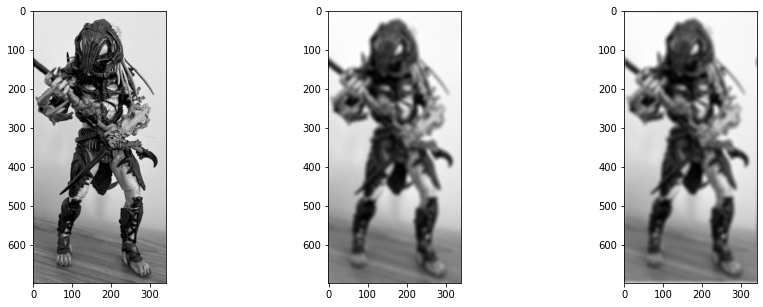

In [235]:
# visualizo ambas imágenes procesadas
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img_1, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img_conv, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img_gauss_2, cmap='gray')

In [236]:
# calculo el índice en ambos casos
iqm_orig = calculate_iqm(img_1)
iqm_conv = calculate_iqm(img_conv)
iqm_spec = calculate_iqm(img_gauss_2)

print(f'IQM imagen original = {iqm_orig}')
print(f'IQM imagen convolucionada = {iqm_conv}')
print(f'IQM imagen filtrada en el dom. espectral = {iqm_spec}')


IQM imagen original = 0.502230923711652
IQM imagen convolucionada = 0.49255098353906007
IQM imagen filtrada en el dom. espectral = 0.41104454284970043


#### 3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

Se implementa el método descrito en A.32. Modiﬁed DCT (DCT3)  


In [243]:
def calculate_dct3(i):
  # generate kernel
  M = np.array([[1, 1, -1, -1], [1, 1, -1, -1], [-1, -1, 1, 1], [-1, -1, 1, 1]], np.float64)

  dct3_filtered = cv.filter2D(i, -1, M)
  return dct3_filtered.sum()

In [244]:
# calculo el índice en ambos casos
dct3_conv = calculate_dct3(img_conv)
dct3_spec = calculate_dct3(img_gauss_2)
dct3_orig = calculate_dct3(img_1)

print(f'DCT3 para la imagen original = {dct3_orig}')
print(f'DCT3 para la imagen convolucionada = {dct3_conv}')
print(f'DCT3 para la imagen convolucionada en el espectro = {dct3_spec}')



DCT3 para la imagen convolucionada = 429325
DCT3 para la imagen convolucionada en el espectro = -9.80200234359976
DCT3 para la imagen coriginal = 4555262
